In [2]:
import cv2
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report

# ЗНАЧЕНИЯ КАТЕГОРИЙ:
<br>
1 - Cargo(Грузовое судно) 
<br>
2 - Militarry(Военное судно)
<br>
3 - Carrier(Корабль-перевозчик)
<br>
4 - Cruise(Круизное судно)
<br>
5 - Tanker(Танкер)

In [3]:
data = pd.read_csv('train.csv')

print(data.head())

         image  category
0  2823080.jpg         1
1  2870024.jpg         1
2  2662125.jpg         2
3  2900420.jpg         3
4  2804883.jpg         2


In [4]:
print(f'Размерность датасета: {data.shape}')
print(f'Колонки в датасете: {data.columns}')
print(f'Пустые значения:\n{data.isnull().sum()}')

Размерность датасета: (6252, 2)
Колонки в датасете: Index(['image', 'category'], dtype='object')
Пустые значения:
image       0
category    0
dtype: int64


In [5]:
import os
import pandas as pd

image_folder = 'images'

def check_image_exists(image_name):
    image_path = os.path.join(image_folder, image_name)
    return os.path.exists(image_path)

data['image_exists'] = data['image'].apply(check_image_exists)

data = data[data['image_exists']]

data.drop(columns=['image_exists'], inplace=True)

In [6]:
data['image'] = data['image'].apply(lambda x: os.path.join('images', x))

data['category'] = data['category'].astype(str)

display(data['image'].iloc[1:10])

3     images\2900420.jpg
5      images\621252.jpg
6     images\2833467.jpg
7     images\2843780.jpg
8     images\2859567.jpg
9     images\2896557.jpg
10    images\2847618.jpg
11    images\2874678.jpg
12    images\2903279.jpg
Name: image, dtype: object

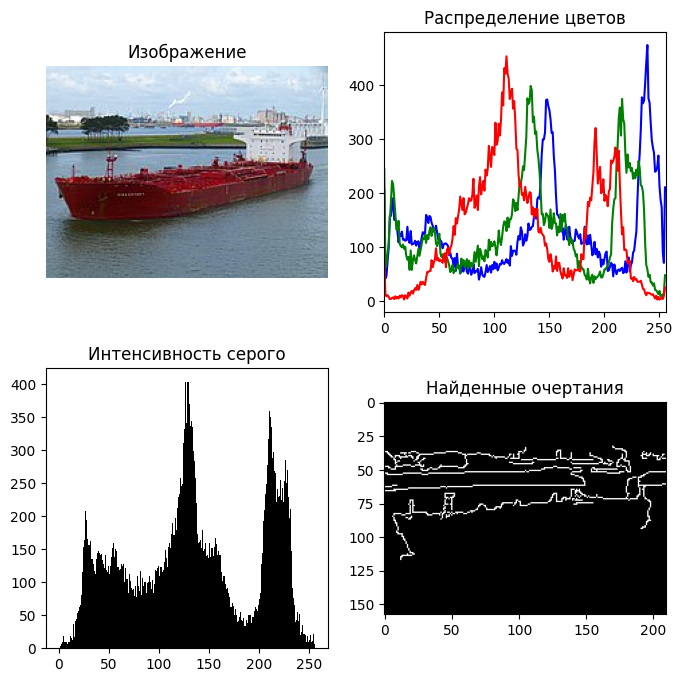

In [7]:
random_image = random.choice(data['image'].tolist())

image = cv2.imread(random_image)

rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.imshow(rgb)
plt.title("Изображение")
plt.axis('off')

colors = ('b', 'g', 'r')
plt.subplot(2, 2, 2)
for i, color in enumerate(colors):
    hist = cv2.calcHist([image], [i], None, [256], [0, 256])
    plt.plot(hist, color=color)
    plt.xlim([0, 256])
plt.title("Распределение цветов")

    
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.subplot(2, 2, 3)
plt.hist(gray_image.ravel(), bins=256, range=[0, 256], color='black')
plt.title("Интенсивность серого")

    
edged_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
edges = cv2.Canny(edged_image, 200, 100)
plt.subplot(2, 2, 4)
plt.imshow(edges, cmap='gray')
plt.title("Найденные очертания")

plt.show()

In [8]:
imggen = ImageDataGenerator(validation_split=0.5, rescale=1./255)

train_generator = imggen.flow_from_dataframe(
    dataframe=data,
    x_col='image',
    y_col='category',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = imggen.flow_from_dataframe(
    dataframe=data,
    x_col='image',
    y_col='category',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 1910 validated image filenames belonging to 5 classes.
Found 1909 validated image filenames belonging to 5 classes.


In [9]:
images, labels = next(train_generator)

plt.figure(figsize=(8, 8))

num_images = 9

for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f'Class: {np.argmax(labels[i]) + 1}')
    plt.axis('off')

plt.show()

KeyboardInterrupt: 

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

C:\Users\plant\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25
)

Epoch 1/25


C:\Users\plant\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.3052 - loss: 1.6119 - val_accuracy: 0.3840 - val_loss: 1.4636
Epoch 2/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.2500 - loss: 0.7580 - val_accuracy: 0.3636 - val_loss: 0.6757
Epoch 3/25


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - accuracy: 0.3742 - loss: 1.4303 - val_accuracy: 0.4191 - val_loss: 1.3700
Epoch 4/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.5625 - loss: 0.4792 - val_accuracy: 0.4091 - val_loss: 0.6183
Epoch 5/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - accuracy: 0.5378 - loss: 1.1334 - val_accuracy: 0.6121 - val_loss: 0.9876
Epoch 6/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.4375 - loss: 0.5816 - val_accuracy: 0.5000 - val_loss: 0.5793
Epoch 7/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.6170 - loss: 0.9413 - val_accuracy: 0.6524 - val_loss: 0.9091
Epoch 8/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.7188 - loss: 0.3528 - val_accuracy: 0.5909 - val_loss: 0.5933
Epoch 9/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - accuracy: 0.6991 - loss: 0.7245 - val_accuracy: 0.7242 - val_loss: 0.7149
Epoch 10/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.6562 - loss: 0.3145 - val_accuracy: 0.7727 -

In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy}')

98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7645 - loss: 0.9840
Validation Accuracy: 0.7683941125869751


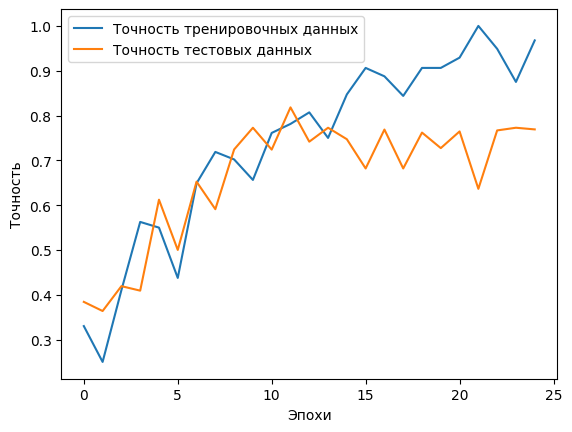

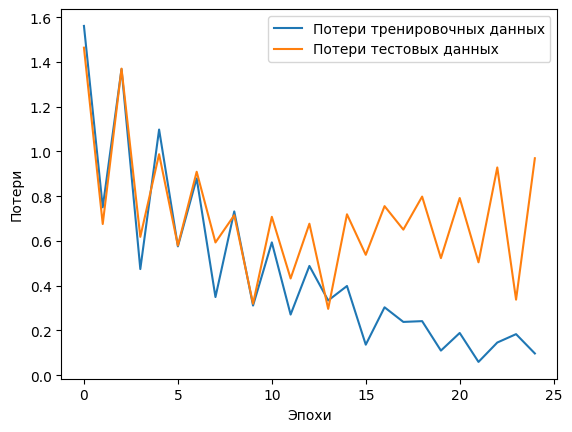

In [ ]:
plt.plot(history.history['accuracy'], label='Точность тренировочных данных')
plt.plot(history.history['val_accuracy'], label='Точность тестовых данных')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Потери тренировочных данных')
plt.plot(history.history['val_loss'], label='Потери тестовых данных')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

plt.show()

98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step


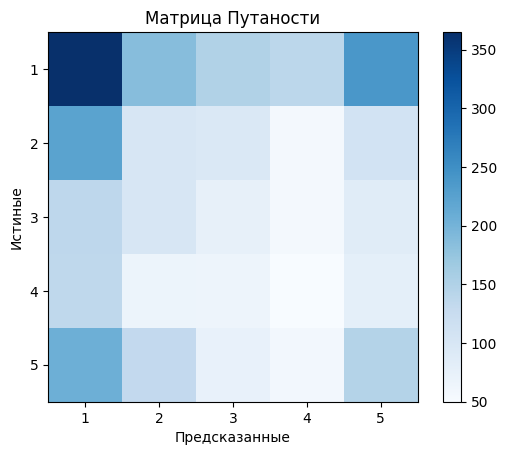

category
1    2120
5    1217
2    1167
3     916
4     832
Name: count, dtype: int64


In [ ]:
predictions = model.predict(validation_generator)
pred_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

matrix = confusion_matrix(true_classes, pred_classes)
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Матрица Путаности')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Предсказанные')
plt.ylabel('Истиные')
plt.show()

counts = data['category'].value_counts()
print(counts)